In [2]:
!pip install kagglehub

     ---------------------------------------- 0.0/40.1 kB ? eta -:--:--
     ---------- ----------------------------- 10.2/40.1 kB ? eta -:--:--
     ----------------------------- -------- 30.7/40.1 kB 325.1 kB/s eta 0:00:01
     ----------------------------- -------- 30.7/40.1 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 40.1/40.1 kB 271.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/70.6 kB ? eta -:--:--
   ---------------------------------- ----- 61.4/70.6 kB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 61.4/70.6 kB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 61.4/70.6 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 70.6/70.6 kB 428.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/160.4 kB ? eta -:--:--
   ---------------------- ----------------- 92.2/160.4 kB 2.6 MB/s eta 0:00:01
   -------------------------------------- - 153.6/160.4 kB 2.3 MB/s eta 0:00:01
 

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sponishflea/classification-of-skin-diseases")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 11.9M/11.9M [00:04<00:00, 2.67MB/s]

Extracting files...


Path to dataset files: C:\Users\USER\.cache\kagglehub\datasets\sponishflea\classification-of-skin-diseases\versions\1


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Setup seed untuk reproducibility (Penting untuk riset/skripsi)
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Konfigurasi Hyperparameter
IMG_SIZE = 224  # Standar EfficientNet
BATCH_SIZE = 32
EPOCHS = 20     # Bisa dinaikkan jika early stopping belum trigger
LEARNING_RATE = 1e-3

print(f"TensorFlow Version: {tf.__version__}")
print("Setup selesai.")

TensorFlow Version: 2.17.0
Setup selesai.


In [7]:
# Cell 2: Load Dataset & Split Data

# Path cukup ke nama folder induknya saja
DATASET_PATH = "datasets" 

# 1. Load Training Data (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

# 2. Load Validation Data (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
print(f"\nKelas ditemukan: {class_names}")
# Output harusnya: ['acne', 'eksim', 'herpes', 'panu', 'rosacea']

Found 1494 files belonging to 5 classes.
Using 1196 files for training.
Found 1494 files belonging to 5 classes.
Using 298 files for validation.

Kelas ditemukan: ['acne', 'eksim', 'herpes', 'panu', 'rosacea']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Pipeline data siap dan teroptimasi.")

Pipeline data siap dan teroptimasi.


Contoh Augmentasi ditampilkan.


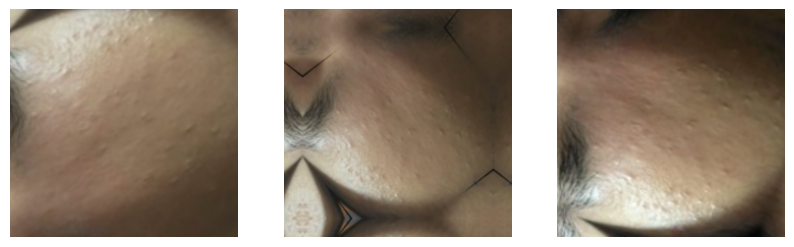

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),      # Rotasi random 20%
    layers.RandomZoom(0.2),          # Zoom in/out random
    layers.RandomContrast(0.2),      # Ubah kontras (penting untuk tekstur kulit)
], name="data_augmentation")

# Visualisasi satu contoh augmentasi
plt.figure(figsize=(10, 3))
for images, _ in train_ds.take(1):
    original_img = images[0]
    for i in range(3):
        augmented_img = data_augmentation(tf.expand_dims(original_img, 0))
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.axis("off")
print("Contoh Augmentasi ditampilkan.")

In [16]:
# 1. Download Pre-trained Model (Tanpa Top Layer)
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_preprocessing=True # V2 sudah punya preprocessing internal
)

# Freeze base model agar bobot ImageNet tidak rusak di awal training
base_model.trainable = False

# 2. Rakit Model Baru
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Augmentasi masuk di dalam model (GPU acc)
x = base_model(x, training=False) # Pastikan training=False saat freeze
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x) # Stabilisasi
x = layers.Dropout(0.3)(x)         # Matikan 30% neuron random (cegah hafal data)

# Output Layer (5 Kelas)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

# 3. Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,930,837 (22.62 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [17]:
callbacks_list = [
    # Stop jika val_loss tidak turun selama 5 epoch
    callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    # Turunkan learning rate jika stuck (agar bisa keluar dari local minima)
    callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=3, 
        min_lr=1e-6,
        verbose=1
    )
]

In [18]:
from sklearn.utils import class_weight
import numpy as np

# 1. Ambil semua label dari dataset training
print("Sedang menghitung bobot kelas (ini mungkin memakan waktu sebentar)...")
y_train_indices = []

# Kita iterasi dataset untuk mengambil label aslinya
for images, labels in train_ds:
    # labels adalah one-hot encoding, kita butuh index (0, 1, 2, dst)
    y_train_indices.extend(np.argmax(labels.numpy(), axis=1))

# 2. Hitung bobot agar kelas yang sedikit/susah punya 'nilai' lebih besar
# 'balanced' artinya otomatis menyesuaikan bobot berbanding terbalik dengan frekuensi
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Ubah ke format dictionary {0: 1.2, 1: 0.8, ...} agar dimengerti Keras
class_weights_dict = dict(enumerate(class_weights_array))

print(f"\nBobot Kelas Ditemukan: {class_weights_dict}")
print("Kelas dengan bobot > 1.0 adalah kelas minoritas/susah.")

# 3. Retrain dengan Class Weights
# Pastikan model sudah di-compile ulang (Jalankan Cell 5 lagi) sebelum ini
print("\n--- Memulai Training Ulang dengan Class Weights ---")
history_weighted = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,             # Gunakan EPOCHS sama (misal 20)
    callbacks=callbacks_list,
    class_weight=class_weights_dict  # <--- INI KUNCINYA
)

Sedang menghitung bobot kelas (ini mungkin memakan waktu sebentar)...

Bobot Kelas Ditemukan: {0: 0.9843621399176955, 1: 0.964516129032258, 2: 1.0050420168067227, 3: 1.000836820083682, 4: 1.0491228070175438}
Kelas dengan bobot > 1.0 adalah kelas minoritas/susah.

--- Memulai Training Ulang dengan Class Weights ---
Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 348ms/step - accuracy: 0.3454 - loss: 1.9080 - val_accuracy: 0.5436 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 298ms/step - accuracy: 0.4922 - loss: 1.3419 - val_accuracy: 0.6275 - val_loss: 1.0799 - learning_rate: 0.0010
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.6031 - loss: 1.0665 - val_accuracy: 0.6678 - val_loss: 0.9488 - learning_rate: 0.0010
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.6237 - loss: 1.0198 - val_accuracy: 0.7081 - val_loss: 0.8581 - learning_rate: 0.0010
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - accuracy: 0.6910 

In [19]:
# Unfreeze base model
base_model.trainable = True

# Bekukan layer awal, latih 20 layer terakhir saja
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile ulang dengan Learning Rate SANGAT KECIL
# Class weight TIDAK PERLU dimasukkan lagi di compile, tapi masuk di fit()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 10x lebih kecil
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n--- Memulai Fine-Tuning (Phase 2) ---")

# Kita gunakan class_weights_dict yang tadi sudah dihitung
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10, # Tambah 10 epoch lagi
    callbacks=callbacks_list,
    class_weight=class_weights_dict # <--- Tetap pakai class weight biar konsisten
)


--- Memulai Fine-Tuning (Phase 2) ---
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 426ms/step - accuracy: 0.7371 - loss: 0.7243 - val_accuracy: 0.7013 - val_loss: 0.7253 - learning_rate: 1.0000e-05
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.7298 - loss: 0.7118 - val_accuracy: 0.7315 - val_loss: 0.6552 - learning_rate: 1.0000e-05
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - accuracy: 0.7459 - loss: 0.6463 - val_accuracy: 0.7550 - val_loss: 0.5872 - learning_rate: 1.0000e-05
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 342ms/step - accuracy: 0.7354 - loss: 0.6759 - val_accuracy: 0.7617 - val_loss: 0.5584 - learning_rate: 1.0000e-05
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.7463 - loss: 0.6762 - val_accuracy: 0.7852 - val_loss: 0.5310 - learning_rate: 1.0000e-05
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


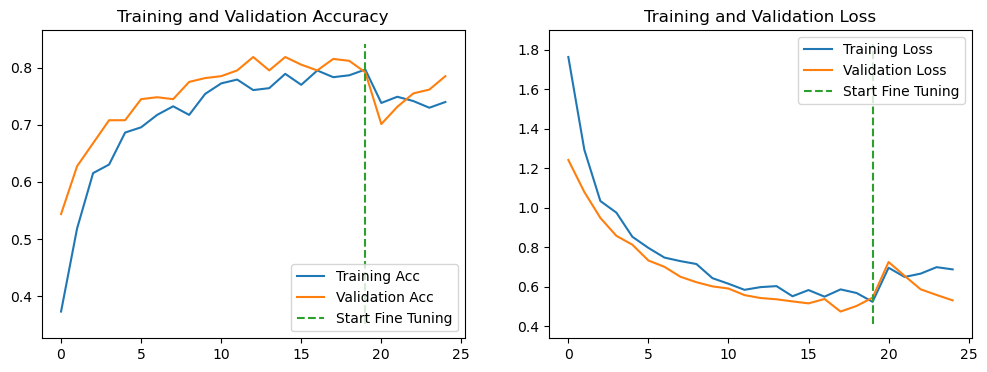

In [20]:
# Menggabungkan history fase 1 (Weighted) dan fase 2 (Fine Tuning)
acc = history_weighted.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_weighted.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_weighted.history['loss'] + history_fine.history['loss']
val_loss = history_weighted.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
# Garis batas fase 1 dan 2
plt.plot([len(history_weighted.history['accuracy'])-1,len(history_weighted.history['accuracy'])-1],
         plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(history_weighted.history['loss'])-1,len(history_weighted.history['loss'])-1],
         plt.ylim(), label='Start Fine Tuning', linestyle='--')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Classification Report:

              precision    recall  f1-score   support

        acne       0.91      0.56      0.70        57
       eksim       0.59      0.67      0.63        49
      herpes       0.75      0.89      0.81        62
        panu       0.55      0.91      0.69        58
     rosacea       0.95      0.50      0.65        72

    accuracy                           0.70       298
   macro avg       0.75      0.71      0.70       298
weighted avg       0.76      0.70      0.70       298



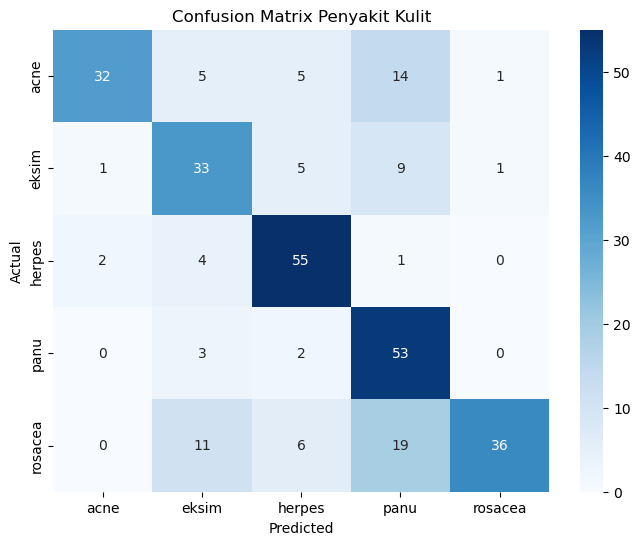

In [21]:
# Ambil label asli dan prediksi
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Penyakit Kulit')
plt.show()

In [24]:
import os

# 1. Gunakan ekstensi .keras (Format Native TensorFlow Terbaru)
# Format ini lebih stabil untuk model dengan layer Augmentation
model_filename = 'skin_disease_efficientnet_v2_finetuned.keras'

# 2. Simpan model
try:
    model.save(model_filename)
    print(f"✅ SUKSES! Model berhasil disimpan: {model_filename}")
    print(f"Path lengkap: {os.path.abspath(model_filename)}")
except Exception as e:
    print(f"❌ Masih error: {e}")
    # Opsi Cadangan: Simpan sebagai Folder (SavedModel format)
    print("Mencoba menyimpan sebagai folder 'saved_model'...")
    model.save('saved_model_skin_disease') 
    print("✅ Berhasil disimpan dalam folder 'saved_model_skin_disease'")

✅ SUKSES! Model berhasil disimpan: skin_disease_efficientnet_v2_finetuned.keras
Path lengkap: C:\Users\USER\Documents\vito file\KULIAH\Data Science\Klasifikasi_Penyakit_Kulit\skin_disease_efficientnet_v2_finetuned.keras


In [2]:
# --- CELL 12: PREDIKSI & PENGUJIAN MODEL ---

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# ================= KONFIGURASI =================
# Pastikan nama file ini SAMA dengan yang kamu simpan di Cell 11
MODEL_FILENAME = 'skin_disease_efficientnet_v2_finetuned.keras'

# Ukuran gambar harus sama persis dengan saat training (EfficientNetB0 = 224)
IMG_SIZE = 224

# Urutan kelas (Wajib urut abjad sesuai folder dataset)
CLASS_NAMES = ['acne', 'eksim', 'herpes', 'panu', 'rosacea']

# ================= 1. LOAD MODEL =================
print(f"🔍 Mencari model: {MODEL_FILENAME} ...")

if os.path.exists(MODEL_FILENAME):
    try:
        # Load model .keras (format baru)
        loaded_model = tf.keras.models.load_model(MODEL_FILENAME)
        print("✅ Model BERHASIL dimuat!")
    except Exception as e:
        print(f"❌ Gagal memuat model: {e}")
        print("Pastikan kamu sudah menjalankan Cell 11 untuk menyimpan model.")
        loaded_model = None
else:
    # Cek jika tersimpan sebagai folder (opsi cadangan)
    if os.path.exists('saved_model_skin_disease'):
        print("📂 Menemukan folder 'saved_model_skin_disease', memuat dari sana...")
        loaded_model = tf.keras.models.load_model('saved_model_skin_disease')
        print("✅ Model BERHASIL dimuat!")
    else:
        print("❌ File model tidak ditemukan. Jalankan Cell 11 dulu!")
        loaded_model = None

# ================= 2. FUNGSI PREDIKSI =================
def predict_skin_disease(image_path):
    if loaded_model is None:
        print("⚠️ Model belum dimuat. Tidak bisa memprediksi.")
        return

    if not os.path.exists(image_path):
        print(f"❌ File gambar tidak ditemukan di: {image_path}")
        return

    try:
        # A. Preprocessing Gambar
        img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Tambah dimensi batch (1, 224, 224, 3)

        # B. Prediksi
        predictions = loaded_model.predict(img_array)
        score = tf.nn.softmax(predictions[0]) # Ubah ke probabilitas (0-1)

        # C. Ambil Hasil
        predicted_class = CLASS_NAMES[np.argmax(score)]
        confidence = 100 * np.max(score)

        # D. Visualisasi
        plt.figure(figsize=(12, 5))

        # --- Plot 1: Gambar Asli ---
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Diagnosa: {predicted_class}\nKeyakinan: {confidence:.2f}%", fontsize=14, color='blue')
        plt.axis('off')

        # --- Plot 2: Grafik Batang Probabilitas ---
        plt.subplot(1, 2, 2)
        # Warna merah jika probabilitas < 5%, Hijau jika tinggi
        bar_colors = ['lightgray' if x < np.max(score) else 'green' for x in score]
        
        bars = plt.bar(CLASS_NAMES, 100 * score, color=bar_colors)
        plt.title("Analisis Probabilitas per Penyakit", fontsize=12)
        plt.ylabel("Kemungkinan (%)")
        plt.ylim([0, 100])
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Tambahkan angka di atas batang
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print(f" >> Hasil Akhir: {predicted_class} ({confidence:.2f}%)")

    except Exception as e:
        print(f"❌ Terjadi kesalahan saat memproses gambar: {e}")



🔍 Mencari model: skin_disease_efficientnet_v2_finetuned.keras ...
✅ Model BERHASIL dimuat!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


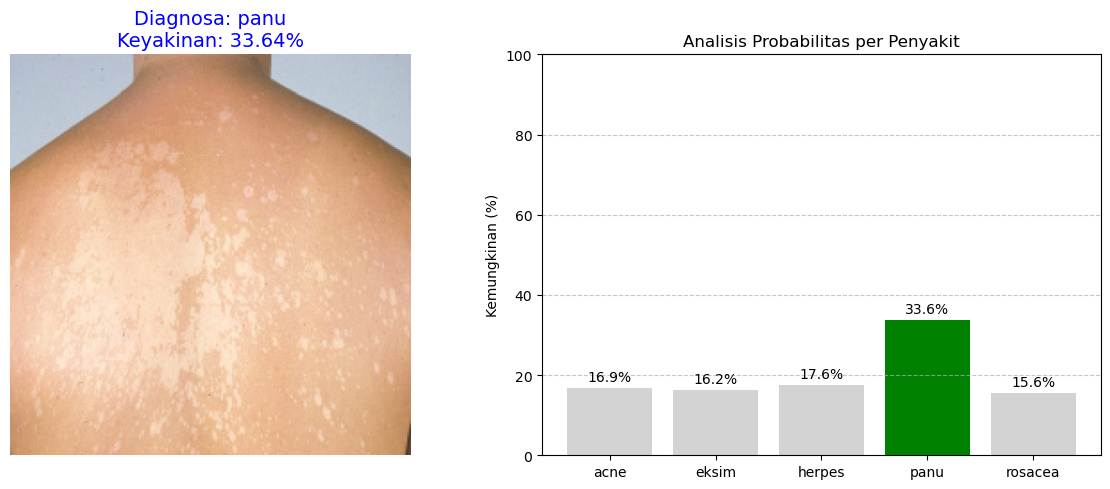

 >> Hasil Akhir: panu (33.64%)


In [30]:
TEST_IMAGE = "tesimage/panu.jpg"  
predict_skin_disease(TEST_IMAGE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


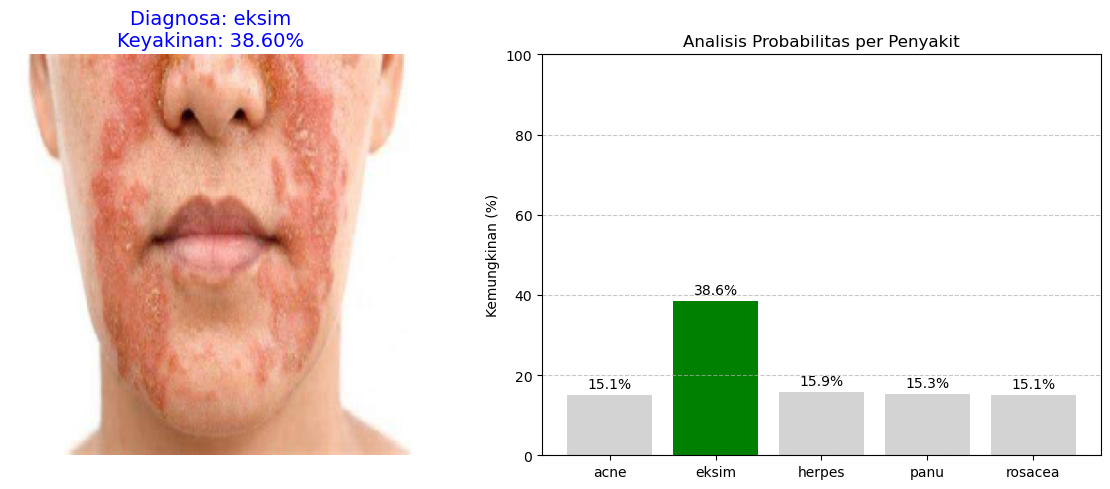

 >> Hasil Akhir: eksim (38.60%)


In [31]:
TEST_IMAGE = "tesimage/eksim.jpg"  
predict_skin_disease(TEST_IMAGE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


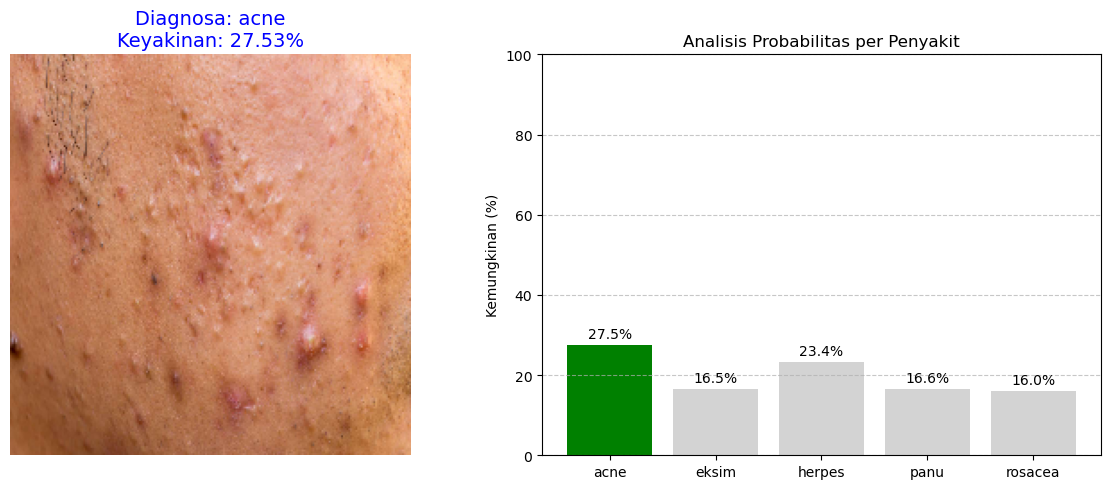

 >> Hasil Akhir: acne (27.53%)


In [32]:
TEST_IMAGE = "tesimage/acne.jpg"  
predict_skin_disease(TEST_IMAGE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


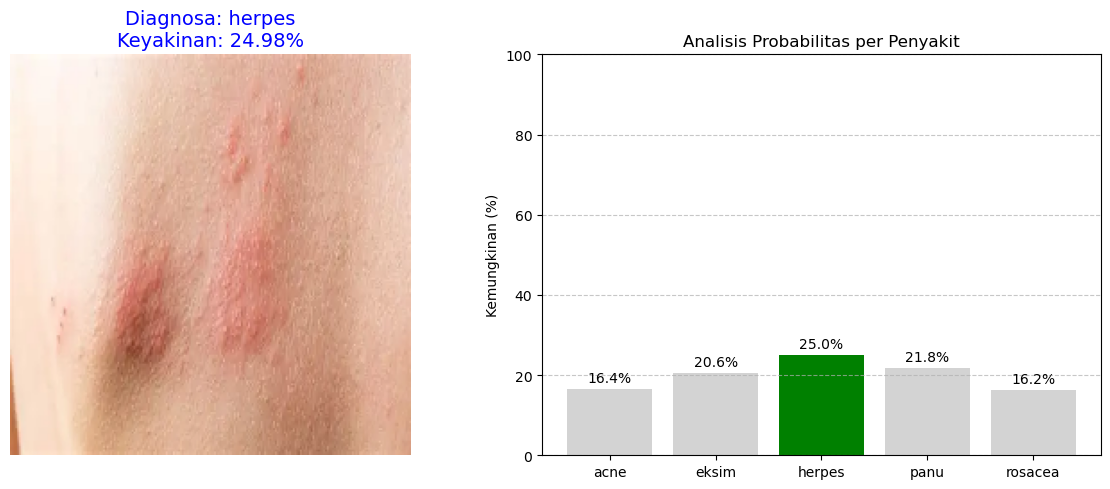

 >> Hasil Akhir: herpes (24.98%)


In [33]:
TEST_IMAGE = "tesimage/herpes.jpg"  
predict_skin_disease(TEST_IMAGE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


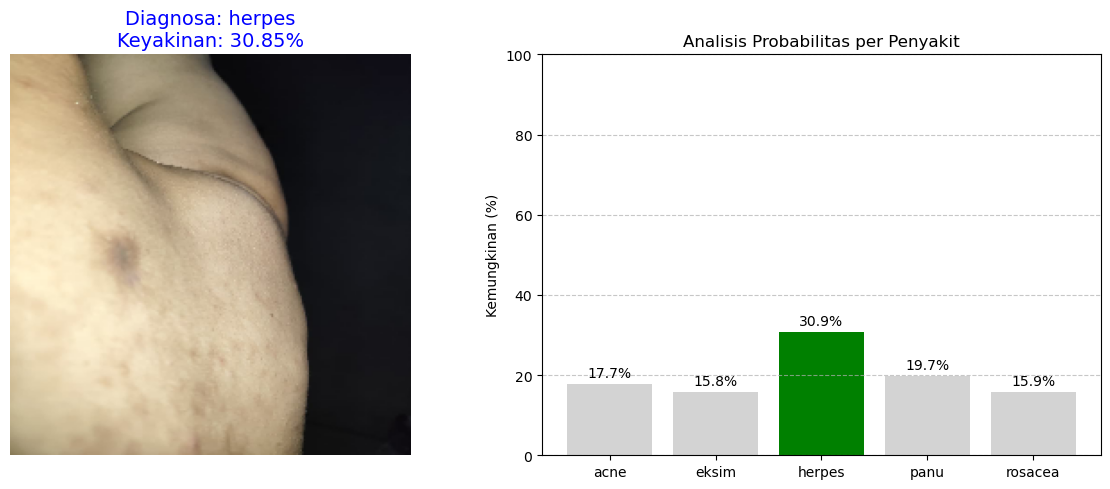

 >> Hasil Akhir: herpes (30.85%)


In [34]:
TEST_IMAGE = "tesimage/vito.jpeg"  
predict_skin_disease(TEST_IMAGE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


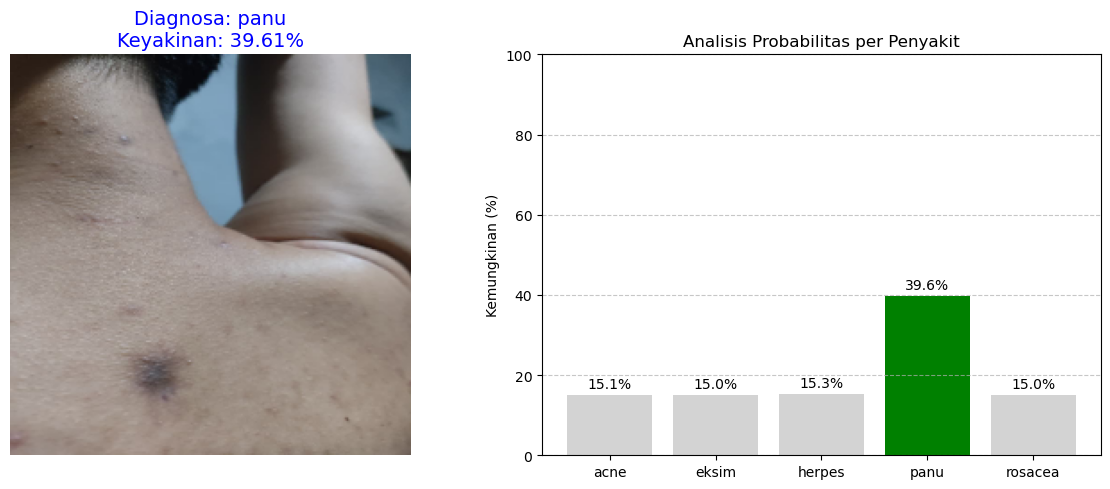

 >> Hasil Akhir: panu (39.61%)


In [3]:
TEST_IMAGE = "tesimage/vito2.jpeg"  
predict_skin_disease(TEST_IMAGE)